In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
#!pip install pmdarima --quiet
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
ari = pd.read_csv("data_ari.csv",sep=",",dtype={'location':str,'year_week':str,
                                                'value':np.float32,'relative_humidity_2m':np.float64,
                                                'temperature_2m_max':np.float64,'temperature_2m_min':np.float64},
                                                parse_dates=['truth_date'])
ari = ari.drop(columns=['Unnamed: 0']).reset_index(drop=True)
ari.tail()

,location,truth_date,year_week,value,relative_humidity_2m,temperature_2m_max,temperature_2m_min,covid
5261,RO,2024-10-13,2024-W41,917.299988,69.57961,22.888000,11.746333,0
5262,DE,2024-10-13,2024-W41,1913.000000,80.27663,16.115000,8.390000,0
5263,HU,2024-10-13,2024-W41,2191.800049,79.25637,19.500666,10.467334,0
5264,SI,2024-10-13,2024-W41,1748.699951,83.50453,18.756998,11.148666,0
5265,BE,2024-10-13,2024-W41,1384.099976,82.94098,14.331166,9.156167,0


In [3]:
#BE#
ari_BE = ari[ari['location']=="BE"]
train = ari_BE[ari_BE['truth_date']<="2023-09-01"]
test = ari_BE[ari_BE['truth_date']>"2023-09-01"]

In [4]:
test.tail()

,location,truth_date,year_week,value,relative_humidity_2m,temperature_2m_max,temperature_2m_min,covid
5211,BE,2024-09-15,2024-W37,927.000000,80.122280,16.550215,8.150214,0
5224,BE,2024-09-22,2024-W38,993.000000,79.679146,22.028788,13.171644,0
5237,BE,2024-09-29,2024-W39,1216.599976,80.408250,16.443071,10.043071,0
5247,BE,2024-10-06,2024-W40,1182.000000,80.857180,15.843072,7.521643,0
5265,BE,2024-10-13,2024-W41,1384.099976,82.940980,14.331166,9.156167,0


In [5]:
ari_BE.head()

,location,truth_date,year_week,value,relative_humidity_2m,temperature_2m_max,temperature_2m_min,covid
7,BE,2014-10-05,2014-W40,1407.500000,89.691070,13.761500,11.761500,0
17,BE,2014-10-12,2014-W41,1493.699951,83.316520,16.800785,10.586500,0
24,BE,2014-10-19,2014-W42,1441.300049,82.441345,18.193644,12.500786,0
30,BE,2014-10-26,2014-W43,1514.000000,79.805950,14.386499,9.779358,0
40,BE,2014-11-02,2014-W44,1401.199951,85.263450,16.029356,10.650786,0


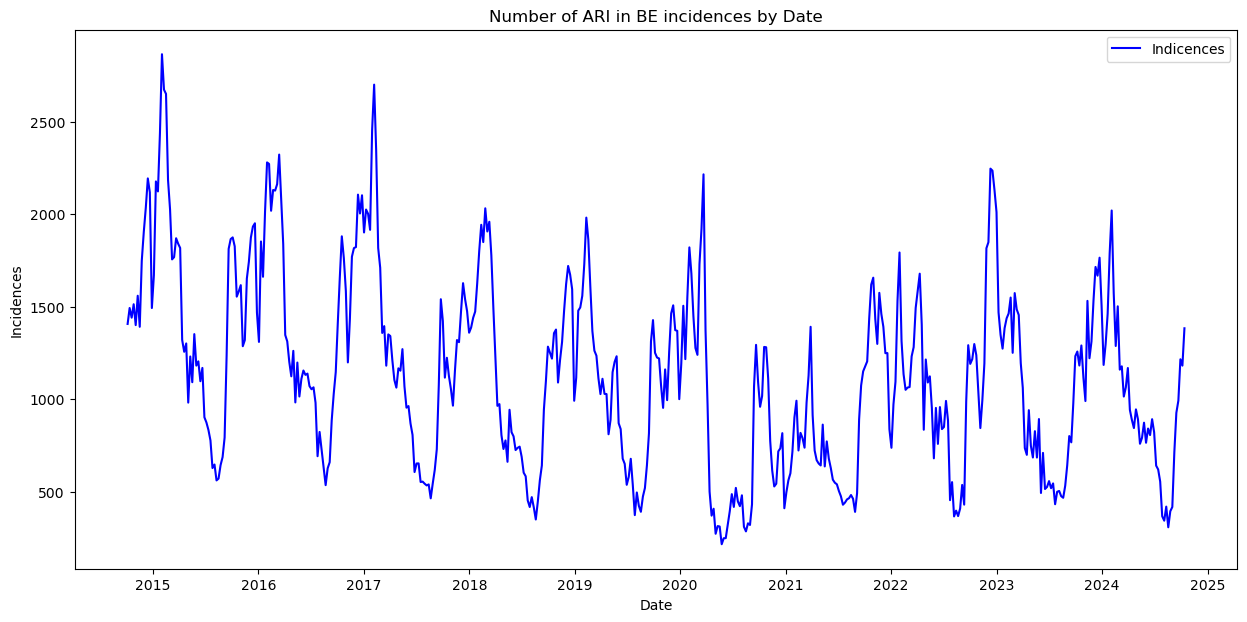

In [6]:
import matplotlib.dates as mdates
plt.figure(figsize=(15, 7))
plt.title("Number of ARI in BE incidences by Date")
plt.xlabel('Date')
plt.ylabel('Incidences')
plt.plot(ari_BE['truth_date'], ari_BE['value'], label='Indicences', color='blue')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Tick every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()  
plt.show()

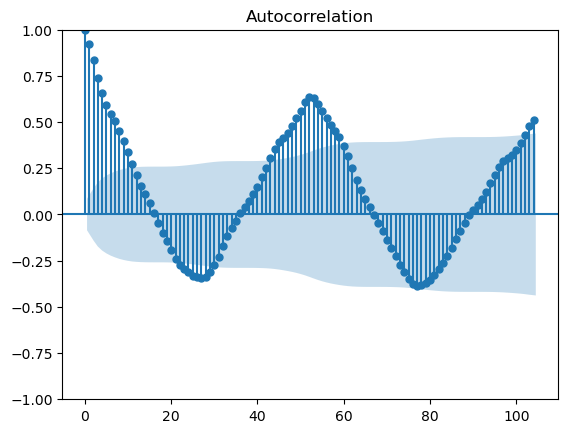

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ari_BE['value'], lags=104)  # Check 2 years (104 weeks)
plt.show()

C:\Users\flore\AppData\Local\Temp\ipykernel_11020\858665072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ari_BE["rolling_avg"] = ari_BE["value"].rolling(window=12).mean()  # 12 represents 12 periods (e.g., months)
C:\Users\flore\AppData\Local\Temp\ipykernel_11020\858665072.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ari_BE["rolling_std"] = ari_BE["value"].rolling(window=12).std()


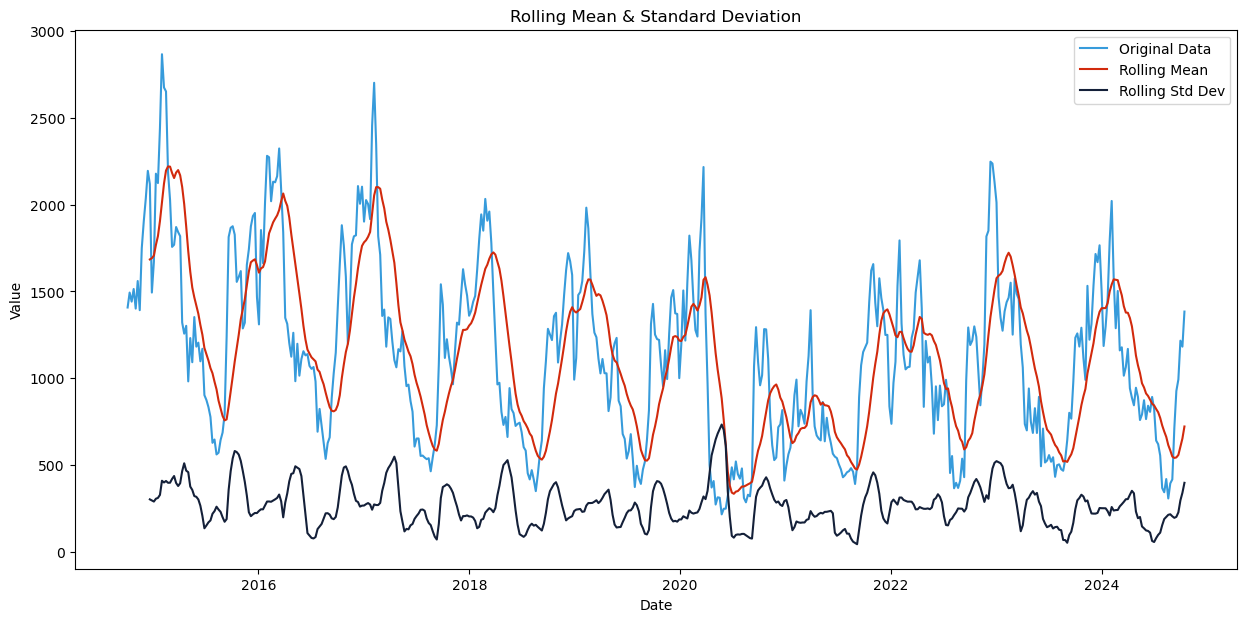

In [7]:
# Calculate rolling statistics
ari_BE["rolling_avg"] = ari_BE["value"].rolling(window=12).mean()  # 12 represents 12 periods (e.g., months)
ari_BE["rolling_std"] = ari_BE["value"].rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(15, 7))
plt.plot(ari_BE["truth_date"], ari_BE["value"], color='#379BDB', label='Original Data')  # Original data
plt.plot(ari_BE["truth_date"], ari_BE["rolling_avg"], color='#D22A0D', label='Rolling Mean')  # Rolling mean
plt.plot(ari_BE["truth_date"], ari_BE["rolling_std"], color='#142039', label='Rolling Std Dev')  # Rolling std dev
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


In [8]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(ari_BE['value'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -5.292725
p-value                          0.000006
#Lags Used                       2.000000
Number of Observations Used    521.000000
Critical Value (1%)             -3.442964
Critical Value (5%)             -2.867103
Critical Value (10%)            -2.569733
dtype: float64


The data is stationary, so we can apply. This means that we can use Sarima. 

In [9]:
ARIMA_model = pm.auto_arima(ari_BE['value'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will b

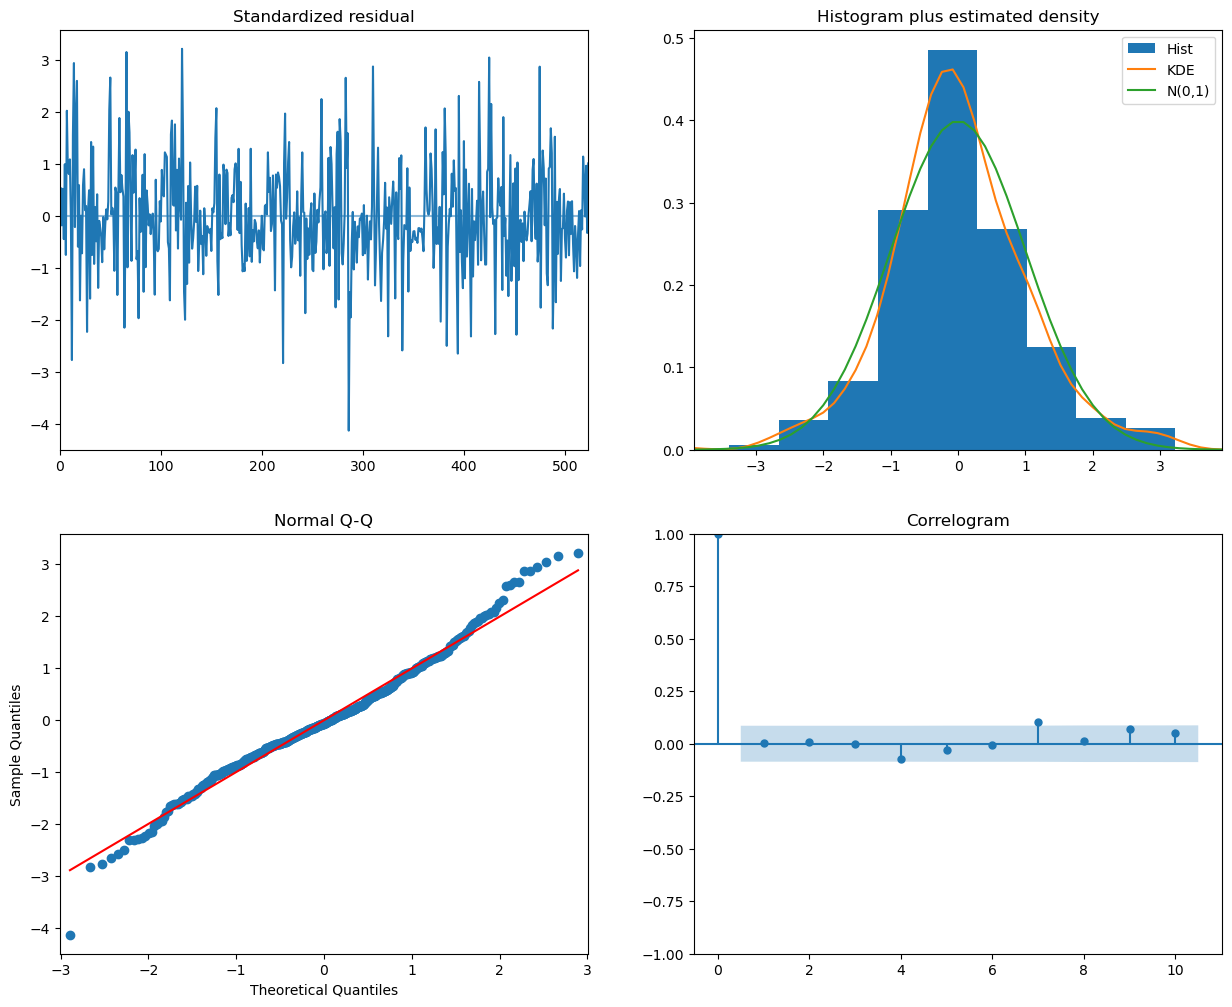

In [10]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [11]:
# Extract the last date from 'truth_date'
last_date = ari_BE[ari_BE["truth_date"]>'2024-08-01']
last_date

,location,truth_date,year_week,value,relative_humidity_2m,temperature_2m_max,temperature_2m_min,covid,rolling_avg,rolling_std
5146,BE,2024-08-04,2024-W31,343.600006,78.415990,24.621643,16.971643,0,693.425003,189.238635
5161,BE,2024-08-11,2024-W32,419.600006,70.350910,25.914501,16.143072,0,662.433337,201.755815
5169,BE,2024-08-18,2024-W33,307.899994,76.241960,24.028788,16.285929,0,615.300003,213.678951
5185,BE,2024-08-25,2024-W34,394.700012,71.899360,22.750216,14.143072,0,584.433339,216.802581
5192,BE,2024-09-01,2024-W35,417.600006,73.244330,25.757357,15.314501,0,549.075005,205.288860
5206,BE,2024-09-08,2024-W36,713.599976,83.573364,21.750214,15.071643,0,541.333336,196.251303
5211,BE,2024-09-15,2024-W37,927.000000,80.122280,16.550215,8.150214,0,544.216667,202.046688
5224,BE,2024-09-22,2024-W38,993.000000,79.679146,22.028788,13.171644,0,558.449999,227.786222
5237,BE,2024-09-29,2024-W39,1216.599976,80.408250,16.443071,10.043071,0,606.391665,296.872887
5247,BE,2024-10-06,2024-W40,1182.000000,80.857180,15.843072,7.521643,0,653.183332,340.363577


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


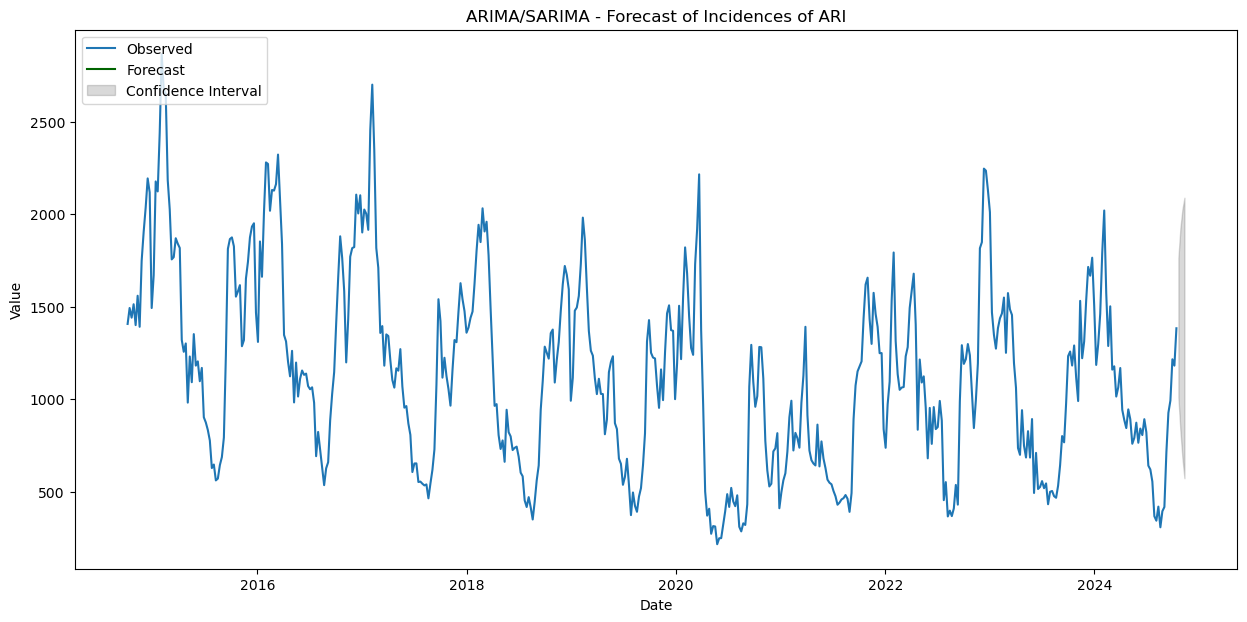

In [12]:
def forecast(ARIMA_model, periods=8):
    # Forecast for the specified number of periods
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    
    # Extract the last date from 'truth_date' greater than '2024-08-01'
    last_date = ari_BE[ari_BE["truth_date"] > '2024-08-01']["truth_date"].iloc[-1]  # Assign it to last_date

    # Create a weekly index for the forecasted periods
    index_of_fc = pd.date_range(start=last_date + pd.DateOffset(weeks=1), periods=n_periods, freq='W')

    # Create series for the forecast and confidence intervals
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot the observed data and the forecast
    plt.figure(figsize=(15, 7))
    plt.plot(ari_BE["truth_date"], ari_BE["value"], color='#1f76b4', label='Observed')  # Plot observed values
    plt.plot(fitted_series, color='darkgreen', label='Forecast')  # Plot forecast values
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=0.15, label='Confidence Interval')  # Add confidence intervals
    plt.legend(loc='upper left')
    plt.title("ARIMA/SARIMA - Forecast of Incidences of ARI")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.show()

# Call the function
forecast(ARIMA_model, periods=4)  # Forecast for 4 weeks


In [13]:
pd.date_range(start='2024-08-11',end='2024-10-13',periods=10)


DatetimeIndex(['2024-08-11', '2024-08-18', '2024-08-25', '2024-09-01',
               '2024-09-08', '2024-09-15', '2024-09-22', '2024-09-29',
               '2024-10-06', '2024-10-13'],
              dtype='datetime64[ns]', freq=None)

In [14]:
(ari_BE.iloc[-60:]['truth_date'])

4567   2023-08-27
4581   2023-09-03
4590   2023-09-10
4598   2023-09-17
4608   2023-09-24
4629   2023-10-01
4640   2023-10-08
4645   2023-10-15
4661   2023-10-22
4680   2023-10-29
4692   2023-11-05
4699   2023-11-12
4717   2023-11-19
4726   2023-11-26
4735   2023-12-03
4747   2023-12-10
4765   2023-12-17
4775   2023-12-24
4791   2023-12-31
4801   2024-01-07
4821   2024-01-14
4833   2024-01-21
4848   2024-01-28
4861   2024-02-04
4874   2024-02-11
4881   2024-02-18
4898   2024-02-25
4910   2024-03-03
4915   2024-03-10
4938   2024-03-17
4940   2024-03-24
4958   2024-03-31
4965   2024-04-07
4985   2024-04-14
4991   2024-04-21
5008   2024-04-28
5019   2024-05-05
5037   2024-05-12
5046   2024-05-19
5051   2024-05-26
5061   2024-06-02
5069   2024-06-09
5085   2024-06-16
5091   2024-06-23
5102   2024-06-30
5111   2024-07-07
5120   2024-07-14
5129   2024-07-21
5140   2024-07-28
5146   2024-08-04
5161   2024-08-11
5169   2024-08-18
5185   2024-08-25
5192   2024-09-01
5206   2024-09-08
5211   202

In [15]:
def forecast(ARIMA_model, start_date='2024-08-11', periods=10):
    # Forecast for the specified number of periods
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    
    # Create a weekly index for the forecasted periods
    index_of_fc = pd.date_range(start=start_date, periods=n_periods, freq='W')

    # Create series for the forecast and confidence intervals
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot the observed data and the forecast
    plt.figure(figsize=(15, 7))
    plt.plot(ari_BE["truth_date"], ari_BE["value"], color='#1f76b4', label='Observed')  # Plot observed values
    plt.plot(fitted_series, color='yellow', label='Forecast')  # Plot forecast values
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=0.15, label='Confidence Interval')  # Add confidence intervals
    plt.legend(loc='upper left')
    plt.title("ARIMA/SARIMA - Forecast of Incidences of ARI")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.show()




c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


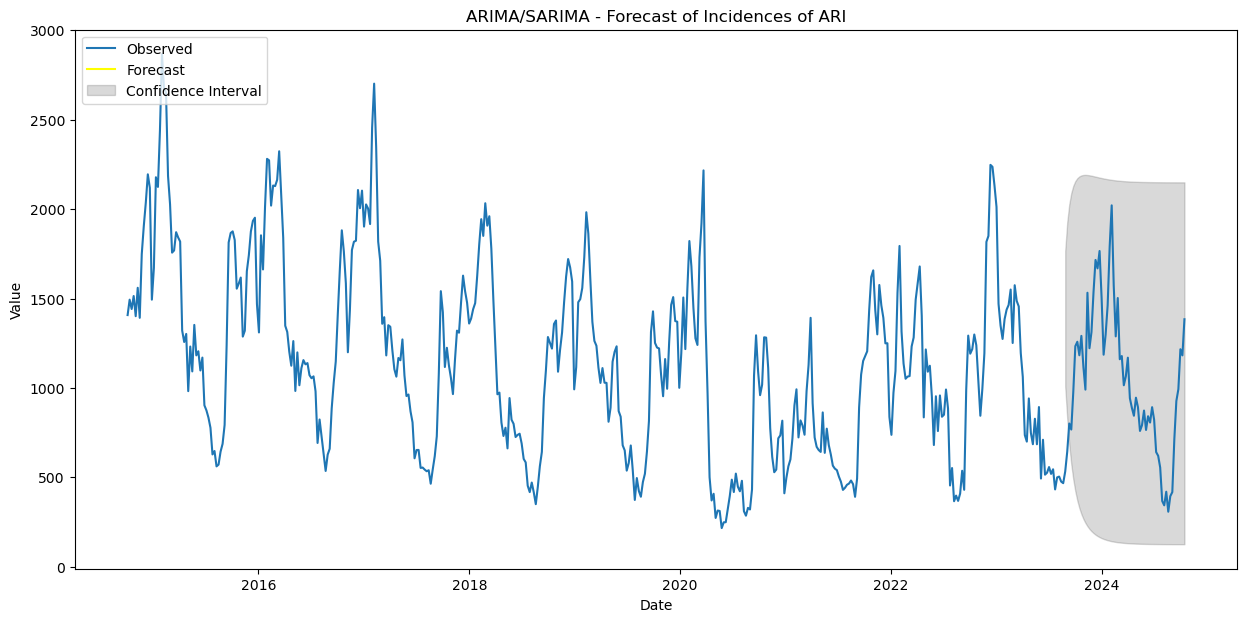

In [16]:
# Call the function for 10 weeks from '2024-08-11'
forecast(ARIMA_model, start_date='2023-08-27', periods=60)

In [17]:
n_periods = 20
fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [18]:
fitted

524    1387.298488
525    1377.991240
526    1355.137861
527    1331.700233
528    1309.443955
529    1289.330150
530    1271.409006
531    1255.549884
532    1241.551125
533    1229.208086
534    1218.329737
535    1208.744045
536    1200.298046
537    1192.856470
538    1186.299954
539    1180.523264
540    1175.433660
541    1170.949423
542    1166.998551
543    1163.517606
dtype: float64

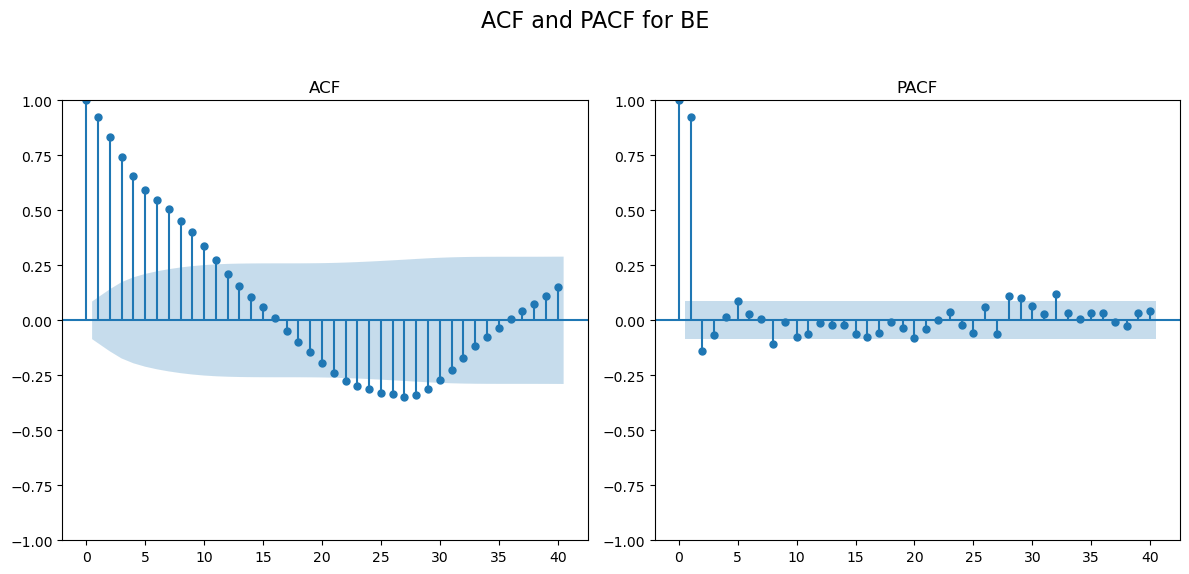

In [19]:
# Create a figure for the plots
plt.figure(figsize=(12, 6))
plt.suptitle(f"ACF and PACF for BE", fontsize=16)

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(ari_BE['value'], lags=40, ax=plt.gca())
plt.title("ACF")

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(ari_BE['value'], lags=40, ax=plt.gca(), method='ywm')
plt.title("PACF")

# Show the plots for the current country
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [20]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(ari_BE["value"], start_p=1, start_q=1,
                        test='adf',
                        max_p=3, max_q=3, 
                        m=52, #52 is the frequncy of the cycle because is weekly
                        start_P=0, 
                        seasonal=True, #set to seasonal
                        d=None, 
                        D=1, #order of the seasonal differencing
                        trace=False,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will b

KeyboardInterrupt: 

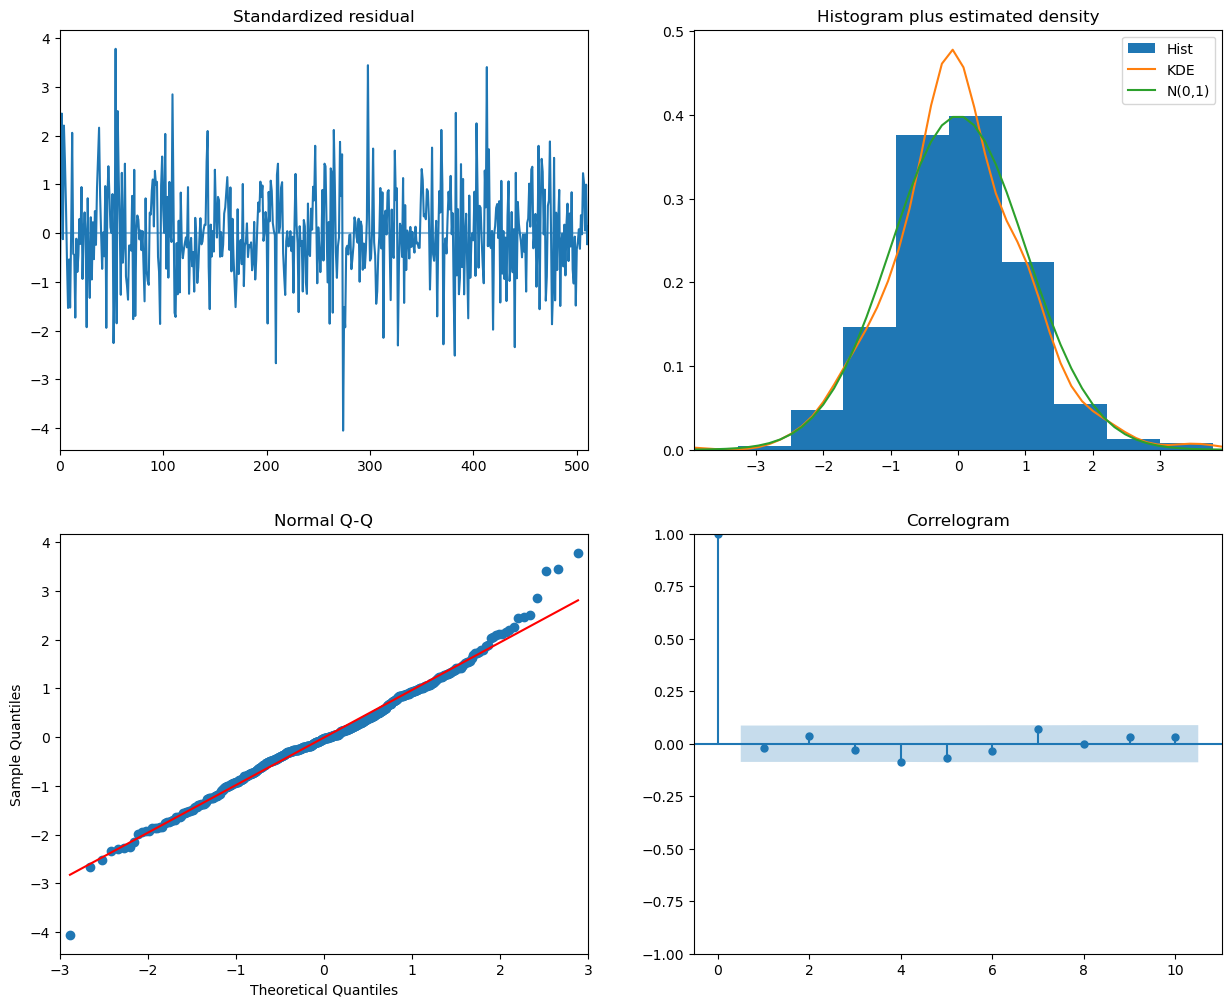

In [ ]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
freq = pd.infer_freq(ari_BE["truth_date"])
print(freq)

In [ ]:
def forecast(model, start_date='2024-08-11', periods=10):
    # Forecast for the specified number of periods
    n_periods = periods
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    
    # Create a weekly index for the forecasted periods
    index_of_fc = pd.date_range(start=start_date, periods=n_periods, freq='W')

    # Create series for the forecast and confidence intervals
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot the observed data and the forecast
    plt.figure(figsize=(15, 7))
    plt.plot(ari_BE["truth_date"], ari_BE["value"], color='#1f76b4', label='Observed')  # Plot observed values
    plt.plot(fitted_series, color='yellow', label='Forecast')  # Plot forecast values
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=0.15, label='Confidence Interval')  # Add confidence intervals
    plt.legend(loc='upper left')
    plt.title("ARIMA/SARIMA - Forecast of Incidences of ARI")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.show()


forecast(SARIMA_model, start_date='2023-08-27', periods=60)
